In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import f1_score
from sklearn.preprocessing import TargetEncoder
import sys

sys.path.insert(0, "..")
from history_based_feature_selection import test_all_features, feature_selection_history

In [2]:
pd.set_option('display.width', 32000)
pd.set_option('display.max_columns', 3000)
pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_rows', 5000)

In [3]:
# Define the model type and hyperparameters that we wish to optimize the
# set of features for. In this example, we use a decision tree.

model_dt = DecisionTreeClassifier()

In [4]:
# Collect the data used and divide into train and validation sets. 

np.random.seed(0)

data = fetch_openml('credit-g', version=1, parser='auto')
x = pd.DataFrame(data.data)
y = data.target

display(x.head())

# If y is numeric, convert to a categorical target
if pd.Series(y).astype(str).str.isnumeric().all():
    y = np.where(pd.Series(y).astype(float) > pd.Series(y).astype(float).median(), 1, 0)  

# If this is a multi-class classification problem, convert to binary classification. This makes the analysis
# simpler and allows us to use target-encoding, which is more straightforward for feature selection than one-hot.
elif pd.Series(y).astype(str).nunique() > 2:
    y = np.where(y == pd.Series(y).mode()[0], 1, 0)

# Shuffle to ensure the target classes are distributed in both the train and validation sets.
x = x.sample(n=len(x))
y = y[x.index]

# Divide into train and validate sets
n_samples = len(x) // 2
x_train = pd.DataFrame(x[:n_samples])
y_train = y[:n_samples]
x_val = pd.DataFrame(x[n_samples:])
y_val = y[n_samples:]

# Remove features that are all null
drop_cols = []
for col_name in x_train.columns:
    if x_train[col_name].count() == 0:
        drop_cols.append(col_name)
x_train = x_train.drop(columns=drop_cols)
x_val = x_val.drop(columns=drop_cols)

# Fill null values
for col_name in x_train.columns:
    if str(x_train[col_name].dtype) == 'category':
        x_train[col_name] = x_train[col_name].fillna(x_train[col_name].cat.categories[0])
        x_val[col_name] = x_val[col_name].fillna(x_train[col_name].cat.categories[0])
    elif x_train[col_name].dtype in [np.float64, np.int64]:
        x_train[col_name] = x_train[col_name].fillna(x_train[col_name].median())
        x_val[col_name] = x_val[col_name].fillna(x_train[col_name].median())
    else:
        x_train[col_name] = x_train[col_name].fillna(x_train[col_name].mode())
        x_val[col_name] = x_val[col_name].fillna(x_train[col_name].mode())

# Encode the categorical values
for col_name in x_train.columns:
    if str(x_train[col_name].dtype) in ['category', 'object']:
        encoder = TargetEncoder()
        encoder.fit(x_train[[col_name]], y_train)
        x_train[col_name] = encoder.transform(x_train[[col_name]]).flatten()
        x_val[col_name] = encoder.transform(x_val[[col_name]]).flatten()  

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes


# Perform a baseline test using all features

In [5]:
test_all_features(model_dt, {}, x_train, y_train, x_val, y_val, metric=f1_score, metric_args={'average':'macro'})

# Using all features we are able to get a macro f1 score of about 0.64. This is the baseline
# we wish to beat. 

Testing with all (20) features: train score: 1.0, validation score: 0.6357243914247173


0.6357243914247173

# Test using history-based feature selection, simply searching for the highest accuracy


Generating the initial set of random candidates...
  0, [1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1], 0.6603988603988604
  1, [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0], 0.6268045366004624
  2, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1], 0.4612585001436644
  3, [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0], 0.6288154182891026
  4, [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 0.6189024390243902
  5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1], 0.4254397595686379
  6, [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1], 0.6343908479773559
  7, [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0], 0.5807463200189996
  8, [0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1], 0.5856831020261279
  9, [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], 0.606085623304635
 10, [1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1], 0.6223637163234479
 11

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Num Features,Score
206,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,-,Y,Y,Y,-,Y,-,Y,-,Y,15,0.706115
201,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,Y,Y,-,-,Y,Y,-,14,0.698192
177,Y,Y,Y,Y,Y,Y,-,-,Y,Y,-,-,Y,Y,-,Y,-,Y,Y,-,13,0.697475
116,Y,Y,Y,Y,-,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,Y,Y,16,0.696866
149,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,Y,Y,Y,-,Y,-,Y,15,0.696443
132,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,-,Y,-,15,0.695868
92,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,-,Y,Y,Y,17,0.694589
197,Y,Y,Y,Y,-,-,Y,Y,Y,-,-,Y,Y,Y,Y,-,-,Y,Y,-,13,0.693236
208,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,Y,Y,Y,Y,-,-,-,Y,-,Y,15,0.691445
75,Y,Y,Y,Y,-,Y,Y,-,Y,Y,-,-,Y,Y,Y,Y,-,Y,Y,Y,15,0.690476


The full set of features is:
   0: checking_status
   1: duration
   2: credit_history
   3: purpose
   4: credit_amount
   5: savings_status
   6: employment
   7: installment_commitment
   8: personal_status
   9: other_parties
  10: residence_since
  11: property_magnitude
  12: age
  13: other_payment_plans
  14: housing
  15: existing_credits
  16: job
  17: num_dependents
  18: own_telephone
  19: foreign_worker


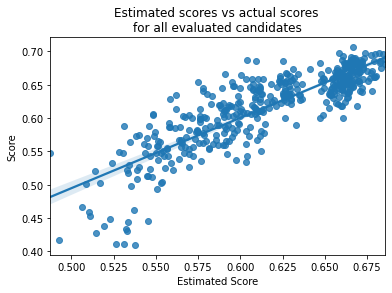

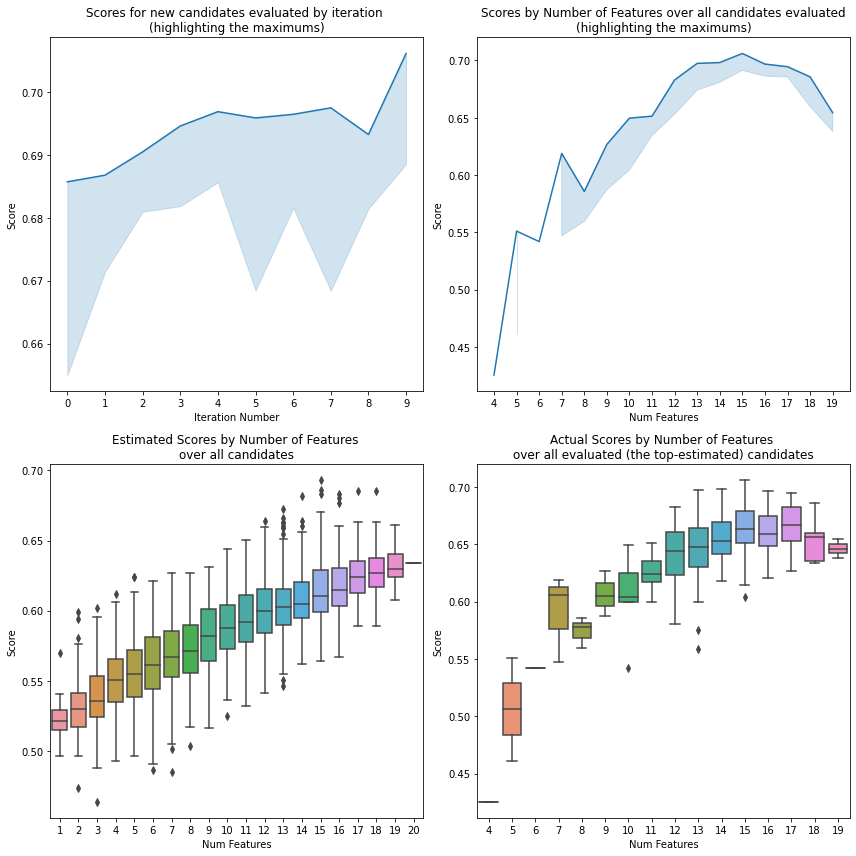

In [6]:
np.random.seed(0)

scores_df = feature_selection_history(
        model_dt, {}, x_train, y_train, x_val, y_val,
        num_iterations=10, num_estimates_per_iteration=5_000, num_trials_per_iteration=25, 
        max_features=None, plot_evaluation=True, penalty=None, 
        verbose=True, draw_plots=True, metric=f1_score, metric_args={'average':'macro'})


# Here we are able to get a score of about 0.71, which beats using all features (0.64)
# This is found with a set of 15 features (the full dataset has 20).

# Test setting the maximum parameters to 5


Generating the initial set of random candidates...
  0, [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0], 0.6159332821244377
  1, [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0], 0.596501764131822
  2, [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 0.5531811559009228
  3, [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], 0.6420505193731496
  4, [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1], 0.6044285707752742
  5, [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0], 0.5552245598791866
  6, [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 0.5360019233080899
  7, [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0], 0.6318670514151397
  8, [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1], 0.5903558052434457
  9, [1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0], 0.5887210870924225
 10, [1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0], 0.5963206847147877
 11

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Num Features,Score
150,Y,-,Y,-,-,Y,-,-,-,Y,-,-,-,-,-,-,-,-,-,Y,5,0.676849
181,Y,-,Y,-,-,Y,-,-,-,Y,-,-,-,-,-,-,-,-,-,-,4,0.676849
217,Y,-,Y,-,-,-,-,-,-,Y,-,-,-,-,-,-,Y,Y,-,-,5,0.671078
178,Y,-,-,-,-,-,-,-,-,Y,-,Y,-,-,-,-,Y,-,-,Y,5,0.670377
200,Y,-,Y,-,-,-,-,-,-,Y,-,-,-,-,-,-,-,-,-,-,3,0.667454
102,Y,-,-,-,Y,-,Y,-,-,Y,-,Y,-,-,-,-,-,-,-,-,5,0.666879
183,Y,-,Y,-,-,-,-,Y,-,-,-,-,-,Y,-,Y,-,-,-,-,5,0.665386
173,Y,Y,Y,-,-,-,Y,-,-,Y,-,-,-,-,-,-,-,-,-,-,5,0.663879
199,Y,-,Y,-,-,-,-,-,-,Y,-,-,-,Y,-,-,-,-,-,Y,5,0.662414
170,Y,-,-,-,-,-,-,-,-,Y,-,Y,-,-,-,-,Y,-,-,-,4,0.661656


The full set of features is:
   0: checking_status
   1: duration
   2: credit_history
   3: purpose
   4: credit_amount
   5: savings_status
   6: employment
   7: installment_commitment
   8: personal_status
   9: other_parties
  10: residence_since
  11: property_magnitude
  12: age
  13: other_payment_plans
  14: housing
  15: existing_credits
  16: job
  17: num_dependents
  18: own_telephone
  19: foreign_worker


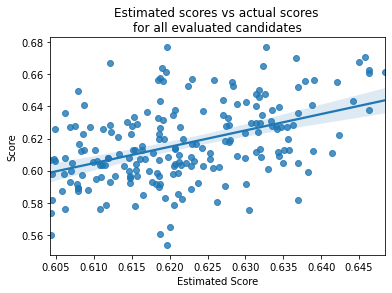

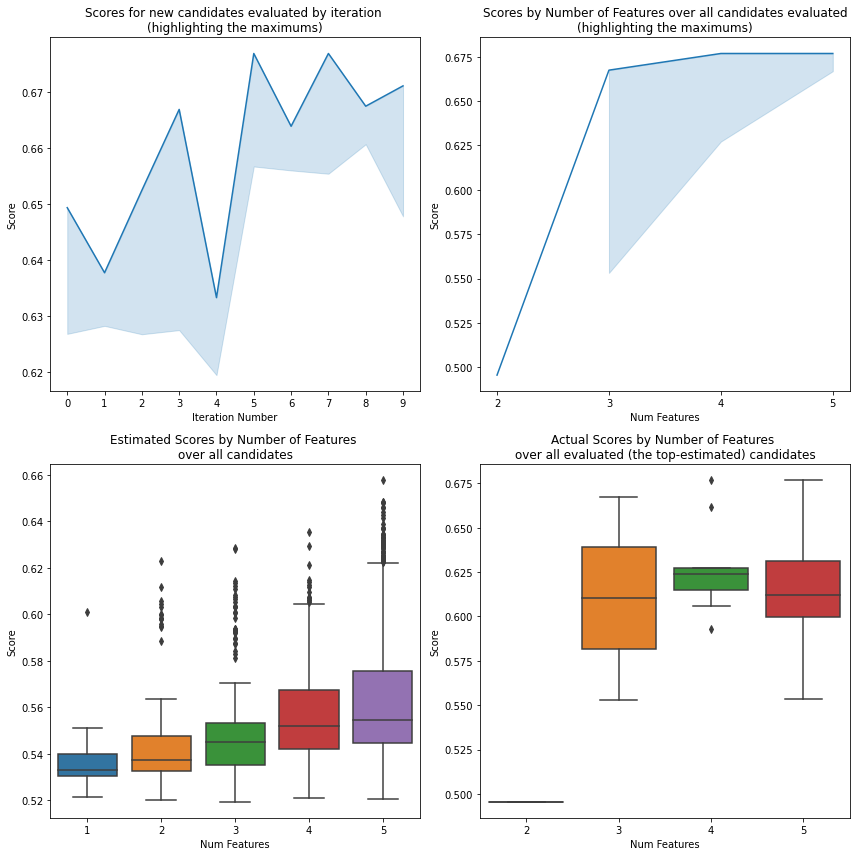

In [7]:
scores_df = feature_selection_history(
        model_dt, {}, x_train, y_train, x_val, y_val,
        num_iterations=10, num_estimates_per_iteration=5_000, num_trials_per_iteration=25, 
        max_features=5, penalty=None, 
        verbose=True, draw_plots=True, metric=f1_score, metric_args={'average':'macro'})

# With only 5 features, it can't do quite as well, but still finds a set that scores about 0.68. 

# Setting the maximum features higher (to 15), but setting a penalty


Generating the initial set of random candidates...
  0, [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1], 0.5324918186068256
  1, [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1], 0.577388677711525
  2, [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 0.4117647058823529
  3, [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0], 0.6391294692427271
  4, [1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1], 0.6319241285684238
  5, [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], 0.44836716681376876
  6, [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1], 0.6213183730715288
  7, [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 0.6483825597749648
  8, [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0], 0.5618442000559738
  9, [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0], 0.5903260439622535
 10, [0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1], 0.5951532025512452
 1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Num Features,Score,Score with Penalty
52,Y,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2,0.667360,0.637360
72,Y,-,Y,-,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,3,0.670509,0.625509
180,Y,-,Y,-,-,Y,-,-,-,-,-,-,-,-,-,-,-,Y,-,-,4,0.678860,0.618860
95,Y,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,Y,3,0.662077,0.617077
77,Y,-,Y,-,-,Y,-,-,-,Y,-,-,-,-,-,-,-,-,-,-,4,0.676849,0.616849
160,Y,-,Y,-,-,-,-,-,-,-,-,-,-,Y,-,-,-,-,-,-,3,0.657206,0.612206
179,Y,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,Y,-,-,-,3,0.656963,0.611963
122,Y,-,Y,-,-,Y,-,-,-,Y,-,-,-,-,-,-,-,Y,-,-,5,0.686901,0.611901
200,Y,-,Y,-,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,Y,4,0.665251,0.605251
202,Y,-,Y,-,-,-,-,-,-,Y,-,-,-,-,-,-,-,Y,-,-,4,0.665145,0.605145


The full set of features is:
   0: checking_status
   1: duration
   2: credit_history
   3: purpose
   4: credit_amount
   5: savings_status
   6: employment
   7: installment_commitment
   8: personal_status
   9: other_parties
  10: residence_since
  11: property_magnitude
  12: age
  13: other_payment_plans
  14: housing
  15: existing_credits
  16: job
  17: num_dependents
  18: own_telephone
  19: foreign_worker


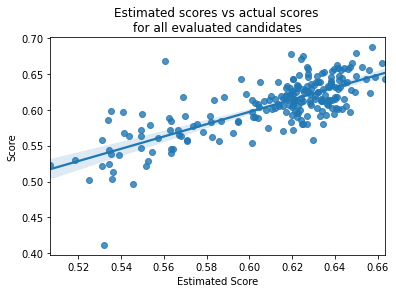

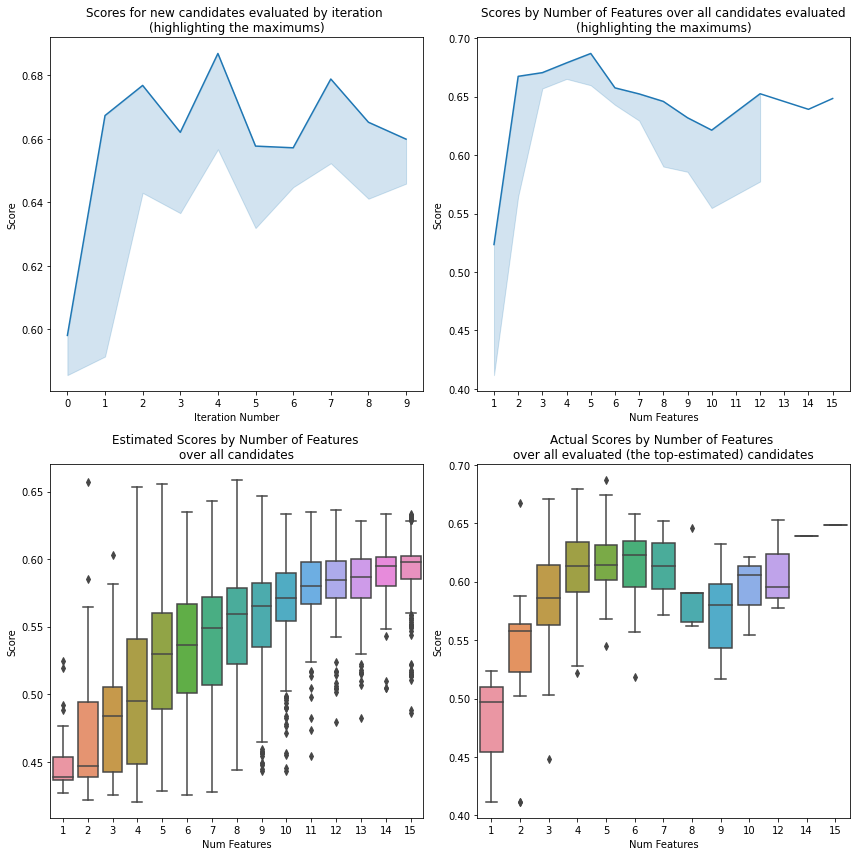

In [8]:
# This sets a penalty of 0.015, which means two feature sets are equivalent if
# one has one more feature than the other, and a score 0.01 higher. 
# For example, this would count a score of 0.80 with 10 features higher than 
# a score of 0.81 with 12 features. 

scores_df = feature_selection_history(
        model_dt, {}, x_train, y_train, x_val, y_val,
        num_iterations=10, num_estimates_per_iteration=5_000, num_trials_per_iteration=25, 
        max_features=15, penalty=0.015, 
        verbose=True, draw_plots=True, metric=f1_score, metric_args={'average':'macro'})

# Setting a penalty of 0.01, it tends to return feature sets close to the maximum of 
# 15 features. Using a larger penalty of 0.015 or 0.02, it tends to select feature 
# sets with about 3 to 8 features. 

In [9]:
# Display the full scores_df. This lists every candidate that was evaluated,
# excluding any with more than max_features features. These are ordered by the
# score with penalty if a penalty was specified. The score_with_penalty value
# is somewhat hard to interpret, but higher is better. 

scores_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Num Features,Score,Score with Penalty
52,Y,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2,0.667360,0.637360
72,Y,-,Y,-,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,3,0.670509,0.625509
180,Y,-,Y,-,-,Y,-,-,-,-,-,-,-,-,-,-,-,Y,-,-,4,0.678860,0.618860
95,Y,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,Y,3,0.662077,0.617077
77,Y,-,Y,-,-,Y,-,-,-,Y,-,-,-,-,-,-,-,-,-,-,4,0.676849,0.616849
160,Y,-,Y,-,-,-,-,-,-,-,-,-,-,Y,-,-,-,-,-,-,3,0.657206,0.612206
179,Y,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,Y,-,-,-,3,0.656963,0.611963
122,Y,-,Y,-,-,Y,-,-,-,Y,-,-,-,-,-,-,-,Y,-,-,5,0.686901,0.611901
200,Y,-,Y,-,-,Y,-,-,-,-,-,-,-,-,-,-,-,-,-,Y,4,0.665251,0.605251
202,Y,-,Y,-,-,-,-,-,-,Y,-,-,-,-,-,-,-,Y,-,-,4,0.665145,0.605145
